# Get data from Yahoo

The first phase of the code is to import and clean the data for yahoo finance
- we only need to run this once then we can use the data contained in the variable hPricesDT repeatedly

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# set up and get the main data 
# get all the tables from the wikipedia page 'https://en.wikipedia.org/wiki/Nasdaq-100#Components' and write them to a pandas dataframe called WikipediaDTs
nasdaq = 'https://en.wikipedia.org/wiki/Nasdaq-100#Components'
WikipediaDTs = pd.DataFrame()
WikipediaDTs = pd.read_html(nasdaq)
len(WikipediaDTs) # this will tell us how many tables there are on the page
tickersLIST = WikipediaDTs[4]['Ticker'].tolist()
#download from yahoo finance the historical data for all tickers in the list and put it in a single dataframe called hPricesDT
hPricesDT = pd.DataFrame()
hPricesDT = yf.download(tickersLIST, start='2010-07-01', end='2021-06-30')['Adj Close']

# identify any tickers with NaN values and list them in a list called tickersNaN
tickersNaN = []
for ticker in tickersLIST:
    if hPricesDT[ticker].isnull().values.any() == True:
        tickersNaN.append(ticker)
hPricesDT.drop(tickersNaN, axis=1, inplace=True) # drop the tickers with NaN values from the dataframe hPricesDT



[*********************100%%**********************]  101 of 101 completed


3 Failed downloads:
['CEG', 'GFS', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1277956800, endDate = 1625025600")


# Build functions

Now we want to convert some of the working parts of the program into functions so that we can repeatedly call them and produce output

The functions we need are:
1.  Get data for the signal period
2.  Find and build momentum portfolios based on performance in the signal period
3.  Plot signal period to see how tickers are selected
4.  Plot portfolio performance corresponding to the long and short portfolios

In [10]:
def get_signal_data(hPricesDT, signal_start_date, signal_months):
    # convert signal_start_date to a timestamp
    signal_start_date = pd.Timestamp(signal_start_date)
    
    # calculate signal_end_date as 1 year after signal_start_date
    signal_end_date = signal_start_date + pd.DateOffset(months=signal_months) + pd.DateOffset(days=-1)

    # create a dataframe called signalDT that contains the prices for the signal period
    signalDT = hPricesDT[signal_start_date:signal_end_date]

    # convert the prices to index values and put them in a dataframe called signalIndexDT
    signalIndexDT = signalDT / signalDT.iloc[0]

    # reset the signal dates to the first and last dates in the signalIndexDT dataframe index (noting that holidays and weekends will be skipped)
    signal_start_date = signalIndexDT.index[0]
    signal_end_date = signalIndexDT.index[-1]

    return signalDT, signalIndexDT, signal_start_date, signal_end_date

def get_top_bottom_tickers(signalDT, signalIndexDT, numPositions):
    
    # create a list of the top performing tickers and bottom performing tickers with the highest index numbers at the end of the period
    topPerformers = signalIndexDT.iloc[-1].nlargest(numPositions).index.tolist()
    bottomPerformers = signalIndexDT.iloc[-1].nsmallest(numPositions).index.tolist()
    otherTickers = signalIndexDT.columns.tolist()
    for ticker in topPerformers:
        otherTickers.remove(ticker)
    for ticker in bottomPerformers:
        otherTickers.remove(ticker)
    
    return topPerformers, bottomPerformers, otherTickers

def plot_signal_period(hPricesIDX, topPerformers, bottomPerformers, otherTickers):
    # create a dataframe called signalIndexDT that contains the index values for all tickers
    signalIndexDT = hPricesIDX / hPricesIDX.iloc[0]

    # plot the index for all tickers in the dataframe signalIndexDT
    plt.figure(figsize=(20,10))
    for ticker in topPerformers:
        plt.plot(signalIndexDT[ticker], color='green')
        plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker, fontsize=12)
    for ticker in bottomPerformers:
        plt.plot(signalIndexDT[ticker], color='red')
        plt.text(signalIndexDT.index[-1], signalIndexDT[ticker].iloc[-1], ticker, fontsize=12)
    for ticker in otherTickers:
        plt.plot(signalIndexDT[ticker], color='lightgrey', linewidth='0.5')
    plt.xlabel('Date', fontsize=18)
    plt.xticks(fontsize=13)
    plt.ylabel('Price Index', fontsize=18)
    plt.yticks(fontsize=13)
    plt.title('Signal period performance - top and bottom performers', fontsize=22)
    # plot gridlines
    plt.grid(which='major', axis='both', linestyle='--')
    plt.show()

    # print the index values for the top performing tickers and bottom performing tickers
    print('Top performing tickers:')
    print(signalIndexDT[topPerformers].iloc[-1])
    print('Bottom performing tickers:')
    print(signalIndexDT[bottomPerformers].iloc[-1])

def get_long_short_portfolios(signatDT, signal_start_date, opening_portfolio_value, topPerformers, bottomPerformers, numPositions):

    # create a dataframe called longPORT that contains the long portfolio
    topPrices = signalDT.iloc[-1][topPerformers].tolist()
    topshareCount = opening_portfolio_value / numPositions / np.array(topPrices)
    longPORTinput = {'Ticker': topPerformers, 'Price': topPrices, 'ShareCount': topshareCount}
    longPORT = pd.DataFrame(longPORTinput)
    longPORT.set_index('Ticker', inplace=True)

    # create a dataframe called shortPORT that contains the short portfolio
    bottomPrices = signalDT.iloc[-1][bottomPerformers].tolist()
    bottomshareCount = opening_portfolio_value / numPositions / np.array(bottomPrices)
    shortPORTinput = {'Ticker': bottomPerformers, 'Price': bottomPrices, 'ShareCount': bottomshareCount}
    shortPORT = pd.DataFrame(shortPORTinput)
    shortPORT.set_index('Ticker', inplace=True)

    return shortPORT, longPORT
    
def run_portfolio_performance(longPORT, shortPORT, hPricesDT, trading_start_date, trading_months):
    # convert trading_start_date to a timestamp
    trading_start_date = pd.Timestamp(trading_start_date)
    
    # calculate trading_end_date as 1 year after trading_start_date
    trading_end_date = trading_start_date + pd.DateOffset(months=trading_months) + pd.DateOffset(days=-1)

    # calculate the values of the long and short portfolios over the trading period
    longPORT_values = hPricesDT[trading_start_date:trading_end_date][longPORT.index]*longPORT['ShareCount']
    shortPORT_values = hPricesDT[trading_start_date:trading_end_date][shortPORT.index]*shortPORT['ShareCount']

    # calculate the total portfolio value for each day
    longPORT_values['Total'] = longPORT_values.sum(axis=1)
    shortPORT_values['Total'] = shortPORT_values.sum(axis=1)

    return longPORT_values, shortPORT_values

def plot_portfolio_performance(longPort_values, shortPort_values):
    # plot the performance of the long and short portfolios over the trading period
    longPort_values['Total'].plot(figsize=(20,10))
    shortPort_values['Total'].plot(figsize=(20,10))
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Portfolio Value', fontsize=18)
    plt.title('Portfolio Value', fontsize=22)
    plt.legend(['Long', 'Short'], fontsize=18)
    plt.show()

# Program which calls the functions and runs them

It is easy to use this streamlined program to change parameters to see their effect on performance

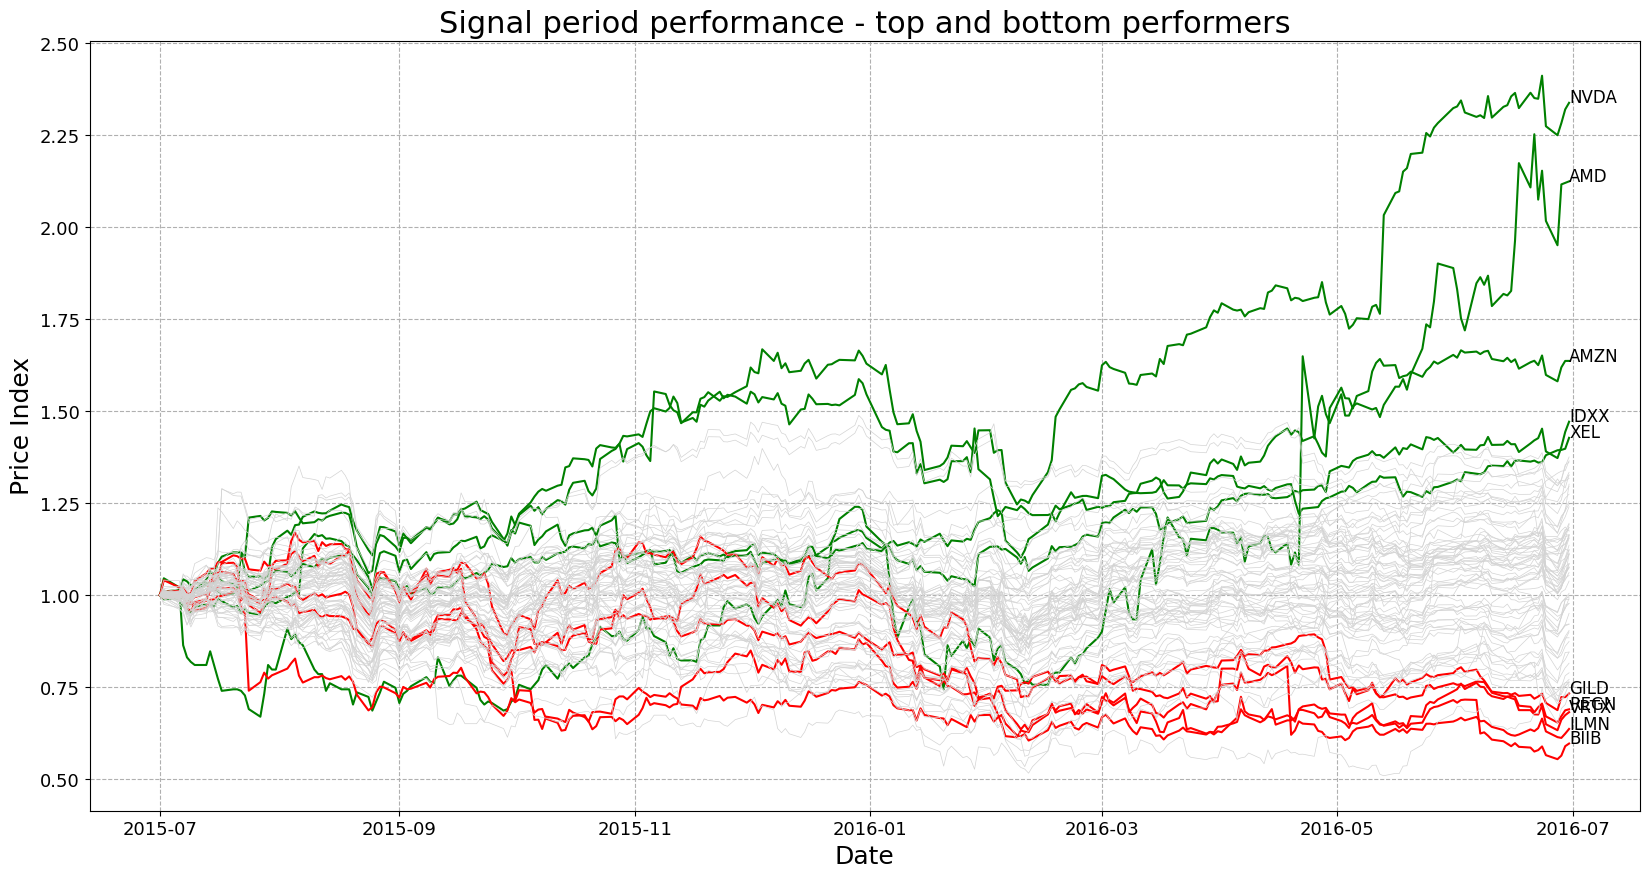

Top performing tickers:
NVDA    2.337412
AMD     2.123967
AMZN    1.636114
IDXX    1.470933
XEL     1.427136
Name: 2016-06-30 00:00:00, dtype: float64
Bottom performing tickers:
BIIB    0.596483
ILMN    0.636125
VRTX    0.681670
REGN    0.689483
GILD    0.732619
Name: 2016-06-30 00:00:00, dtype: float64
            Price  ShareCount
Ticker                       
NVDA    11.546059  173.219283
AMD      5.140000  389.105068
AMZN    35.780998   55.895590
IDXX    92.860001   21.537799
XEL     36.150986   55.323526
             Price  ShareCount
Ticker                        
BIIB    241.820007    8.270614
ILMN    140.380005   14.247043
VRTX     86.019997   23.250408
REGN    349.230011    5.726885
GILD     63.985317   31.257171


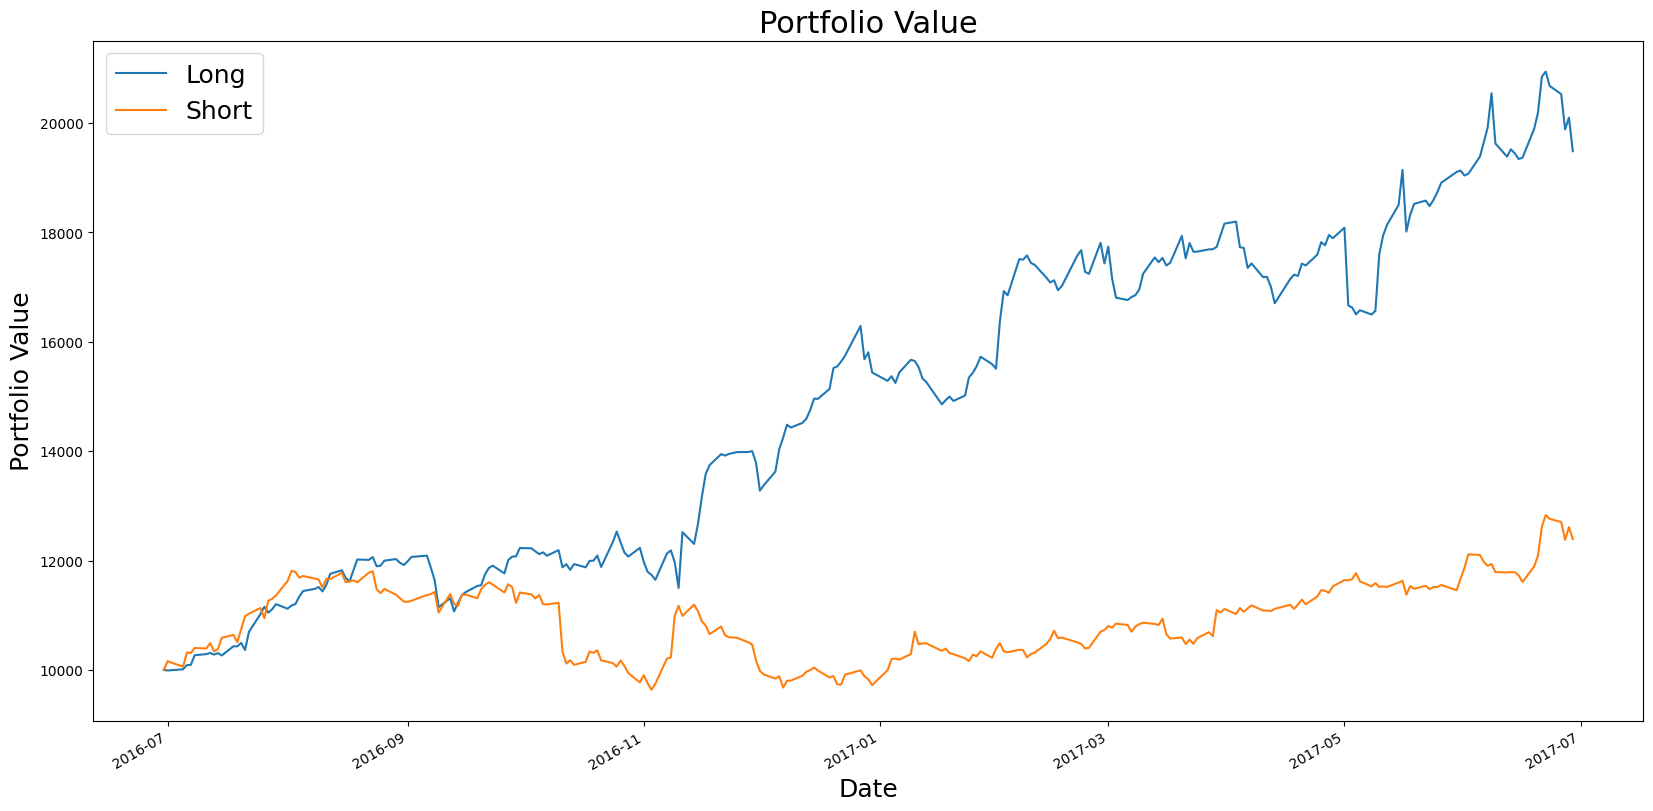

In [11]:
signal_start_date = '2015-07-01'
numPositions = 5
signal_months = 12
trading_months = 12
portfolioSize = 10000

signalDT, signalIndexDT, signal_start_date, signal_end_date = get_signal_data(hPricesDT, signal_start_date, signal_months)
topPerformers, bottomPerformers, otherPerformers = get_top_bottom_tickers(signalDT, signalIndexDT, numPositions)
plot_signal_period(signalDT, topPerformers, bottomPerformers, otherPerformers)
shortPORT, longPORT = get_long_short_portfolios(signalDT, signal_start_date, portfolioSize, topPerformers, bottomPerformers, numPositions)
print(longPORT)
print(shortPORT)
longPort_values, shortPort_values = run_portfolio_performance(longPORT, shortPORT, hPricesDT, signal_end_date, trading_months)
plot_portfolio_performance(longPort_values, shortPort_values)


# Examine rolling (signal/trading) periods and examine varying performance

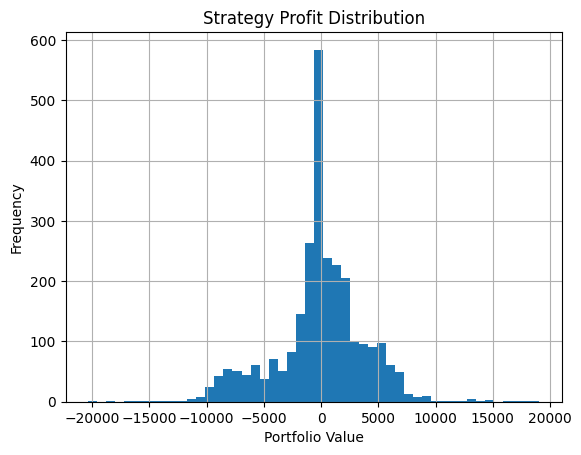

In [12]:
numPositions = 5
signal_months = 12
trading_months = 12
portfolioSize = 10000


#create a pandas dataframe called portfolioPerformance with 3 columns: 'Long_outcome', 'Short_outcome', 'Long-Short'
portfolioPerformance = pd.DataFrame(columns=['Long_outcome', 'Short_outcome', 'Long-Short'])

rolling_period_start_dates = hPricesDT.index[0:-trading_months]

# loop through each trading period and calculate the portfolio performance
for signal_start_date in rolling_period_start_dates:
    signalDT, signalIndexDT, signal_start_date, signal_end_date = get_signal_data(hPricesDT, signal_start_date, signal_months)
    topPerformers, bottomPerformers, otherPerformers = get_top_bottom_tickers(signalDT, signalIndexDT, numPositions)
    shortPORT, longPORT = get_long_short_portfolios(signalDT, signal_start_date, portfolioSize, topPerformers, bottomPerformers, numPositions)
    longPort_values, shortPort_values = run_portfolio_performance(longPORT, shortPORT, hPricesDT, signal_end_date, trading_months)
    portfolioPerformance.loc[signal_start_date] = [longPort_values.iloc[-1]['Total'], shortPort_values.iloc[-1]['Total'], longPort_values.iloc[-1]['Total']-shortPort_values.iloc[-1]['Total']]

# show a histogram of the 'Long-Short' column
portfolioPerformance['Long-Short'].hist(bins=50)
plt.xlabel('Portfolio Value')
plt.ylabel('Frequency')
plt.title('Strategy Profit Distribution')
plt.show()

